In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

with open('DATA.json', 'r') as f:
    results_dict = json.load(f)


## Calculating lambda

In [2]:
import numpy as np 
from typing import Dict, List, Union, Any 


def calculate_lambda(
    results_dict: Dict[str, Dict[str, Dict[str, List[Dict[str, Any]]]]], 
    function_name: str,
    direction: str,
    multiplier: Union[int, float], 
    target_p: float,
    distance_numerator: int = 5,    
    distance_denominator: int = 7   
) -> Union[float, None]:
    try:
        data_for_config = results_dict[function_name][direction][str(multiplier)]
    except KeyError as e:
        print("check keys.")
        return None
    
    l_numerator = None
    l_denominator = None
    
    for entry_dict in data_for_config:
        n = entry_dict['n_distance']
        p_physical = entry_dict['physical_error_rate']
        l_logical = entry_dict['logical_error_rate_calculated'] 
        
        if p_physical == target_p:
            if n == distance_numerator:
                l_numerator = l_logical
            elif n == distance_denominator:
                l_denominator = l_logical
    
    found_numerator = True
    found_denominator = True
    if l_numerator is None:
        found_numerator = False
    if l_denominator is None:
        found_denominator = False
    
    if found_numerator and found_denominator:
        if l_denominator == 0:
            return None
        
        lambda_ratio = l_numerator / l_denominator
        print(f"At P_phy = {target_p}, Lambda (D={distance_numerator}/D={distance_denominator}) = {lambda_ratio}")
        return lambda_ratio
    else:
        return None

Example

In [3]:
import os
import pandas as pd

# Define simulation parameters
function_names = ["Rotated_CAT", "Rotated_Direct", "Rotated_GT", "Unrotated_Direct", "unrotated_CAT", "unrotated_GT"]
directions = ["Horizontal", "Vertical"]
multipliers = [10, 1]
target_p = 0.0034362293368603814
lambda_results = []

# Loop over each simulation parameter combination
for func in function_names:
    for direc in directions:
        for mult in multipliers:
            print(f"Processing: Function = {func}, Direction = {direc}, Multiplier = {mult}")
            lambda_ratio = calculate_lambda(results_dict, func, direc, mult, target_p)
            lambda_results.append({
                "Function": func,
                "Direction": direc,
                "Multiplier": mult,
                "Target_p": target_p,
                "Lambda_Ratio (D=5/D=7)": lambda_ratio
            })

lambda_df = pd.DataFrame(lambda_results)
print("Lambda Ratio Summary:")
print(lambda_df)

# Save the DataFrame to a CSV file
csv_filename = "Full lambda - 0.00345.csv"
lambda_df.to_csv(csv_filename, index=False)
print(f"p Lambda results summary saved to {csv_filename}")

Processing: Function = Rotated_CAT, Direction = Horizontal, Multiplier = 10
At P_phy = 0.0034362293368603814, Lambda (D=5/D=7) = 1.4904837708809586
Processing: Function = Rotated_CAT, Direction = Horizontal, Multiplier = 1
At P_phy = 0.0034362293368603814, Lambda (D=5/D=7) = 1.6017128051392788
Processing: Function = Rotated_CAT, Direction = Vertical, Multiplier = 10
At P_phy = 0.0034362293368603814, Lambda (D=5/D=7) = 3.3851842653878412
Processing: Function = Rotated_CAT, Direction = Vertical, Multiplier = 1
At P_phy = 0.0034362293368603814, Lambda (D=5/D=7) = 3.7431010095972983
Processing: Function = Rotated_Direct, Direction = Horizontal, Multiplier = 10
At P_phy = 0.0034362293368603814, Lambda (D=5/D=7) = 1.6124705166842148
Processing: Function = Rotated_Direct, Direction = Horizontal, Multiplier = 1
At P_phy = 0.0034362293368603814, Lambda (D=5/D=7) = 1.9144662519807885
Processing: Function = Rotated_Direct, Direction = Vertical, Multiplier = 10
At P_phy = 0.0034362293368603814, La

### Plotting two data sets simultaneously with threshold

Plotting/Helpers

In [6]:
from sinter._probability_util import fit_binomial, Fit 

import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import brentq     
from collections import defaultdict 
import matplotlib.ticker as mticker
from matplotlib import colors as mcolors
from typing import Dict, List, Union, Any, Sequence

def find_intersection(p1, l1, p2, l2, tol=1e-9):
    p1, l1, p2, l2 = map(np.array, [p1, l1, p2, l2])
    mask1 = (p1 > 0) & (l1 > 0)
    mask2 = (p2 > 0) & (l2 > 0)
    if not np.all(mask1) or not np.all(mask2):
        p1, l1 = p1[mask1], l1[mask1]
        p2, l2 = p2[mask2], l2[mask2]
        if len(p1) < 2 or len(p2) < 2:
            return None
    log_p1 = np.log10(p1)
    log_l1 = np.log10(l1)
    log_p2 = np.log10(p2)
    log_l2 = np.log10(l2)
    for i, lp_val1 in enumerate(log_p1):
        for j, lp_val2 in enumerate(log_p2):
            if abs(lp_val1 - lp_val2) < tol and abs(log_l1[i] - log_l2[j]) < tol:
                return 10**lp_val1
    for i in range(len(log_p1)-1):
        for j in range(len(log_p2)-1):
            x1, y1 = log_p1[i], log_l1[i]
            x2, y2 = log_p1[i+1], log_l1[i+1]
            x3, y3 = log_p2[j], log_l2[j]
            x4, y4 = log_p2[j+1], log_l2[j+1]
            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if abs(denom) > tol:
                t_num = (x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)
                u_num = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3))
                t = t_num / denom
                u = u_num / denom
                if 0 <= t <= 1 and 0 <= u <= 1:
                    p_int_log = x1 + t * (x2 - x1)
                    return 10**p_int_log
    try:
        if not (len(log_p1) > 1 and len(log_p2) > 1):
             return None
        sort_idx1 = np.argsort(log_p1)
        log_p1, log_l1 = log_p1[sort_idx1], log_l1[sort_idx1]
        sort_idx2 = np.argsort(log_p2)
        log_p2, log_l2 = log_p2[sort_idx2], log_l2[sort_idx2]
        unique_mask1 = np.concatenate(([True], np.diff(log_p1) > tol))
        log_p1, log_l1 = log_p1[unique_mask1], log_l1[unique_mask1]
        unique_mask2 = np.concatenate(([True], np.diff(log_p2) > tol))
        log_p2, log_l2 = log_p2[unique_mask2], log_l2[unique_mask2]
        if len(log_p1) < 2 or len(log_p2) < 2:
             return None
        interp1 = interp1d(log_p1, log_l1, kind='linear', fill_value="extrapolate")
        interp2 = interp1d(log_p2, log_l2, kind='linear', fill_value="extrapolate")
        p_min_log = max(np.min(log_p1), np.min(log_p2))
        p_max_log = min(np.max(log_p1), np.max(log_p2))
        if p_min_log >= p_max_log :
            print(f"No overlapping domain")
            return None
        def func_diff(p_log_val):
            return interp1(p_log_val) - interp2(p_log_val)
        if func_diff(p_min_log) * func_diff(p_max_log) > 0:
            print(f"Interpolated functions do not cross ")
            return None
        p_threshold_log = brentq(func_diff, p_min_log, p_max_log)
        return 10**p_threshold_log
    except Exception as e:
        print(f"Error finding intersection with interpolation: {e}")
        return None

def get_sorted_data(results_dict_loaded, fn, dir_key, mult_key_str):
    try:
        data_list_of_dicts = results_dict_loaded[fn][dir_key][mult_key_str]
    except KeyError as e:
        print(f"KeyError for {fn}, {dir_key}, {mult_key_str}: {e}")
        return None    
    data_by_distance = {}
    for entry_dict in data_list_of_dicts:
        try:
            n = entry_dict['n_distance']
            p_physical = entry_dict['physical_error_rate']
            l_logical = entry_dict['logical_error_rate_calculated'] 
            k_L = entry_dict['logical_errors_observed']
            N_total = entry_dict['shots_conducted']
            n_str = str(n)
            if n_str not in data_by_distance:
                data_by_distance[n_str] = {'p': [], 'l': [], 'k': [], 'N': []}
            data_by_distance[n_str]['p'].append(p_physical)
            data_by_distance[n_str]['l'].append(l_logical)
            data_by_distance[n_str]['k'].append(k_L)
            data_by_distance[n_str]['N'].append(N_total)
        except KeyError as e:
            print(f"Missing key in entry_dict: {e}. Entry: {entry_dict}. Skipping this entry.")
            continue
        except TypeError as e:
            print(f"Type error processing entry_dict: {e}. Entry: {entry_dict}. Skipping this entry.")
            continue
    for dist_str_key in data_by_distance:
        p_arr = np.array(data_by_distance[dist_str_key]['p'])
        l_arr = np.array(data_by_distance[dist_str_key]['l'])
        k_arr = np.array(data_by_distance[dist_str_key]['k'])
        N_arr = np.array(data_by_distance[dist_str_key]['N'])
        if len(p_arr) == 0:
            data_by_distance[dist_str_key] = {'p': np.array([]), 'l': np.array([]), 'k': np.array([]), 'N': np.array([])}
            continue
        idx_sort = np.argsort(p_arr)
        p_sorted = p_arr[idx_sort]
        l_sorted = l_arr[idx_sort]
        k_sorted = k_arr[idx_sort]
        N_sorted = N_arr[idx_sort]
        points_to_keep_indices = []
        for i in range(len(p_sorted)):
            if i < 3: 
                if l_sorted[i] == 0:
                    continue
                if i < len(p_sorted) - 1 and l_sorted[i] > l_sorted[i+1] and l_sorted[i+1] != 0 :
                    continue
            points_to_keep_indices.append(i)
        if not points_to_keep_indices:
            data_by_distance[dist_str_key] = {'p': np.array([]), 'l': np.array([]), 'k': np.array([]), 'N': np.array([])}
        else:
            data_by_distance[dist_str_key]['p'] = p_sorted[points_to_keep_indices]
            data_by_distance[dist_str_key]['l'] = l_sorted[points_to_keep_indices]
            data_by_distance[dist_str_key]['k'] = k_sorted[points_to_keep_indices]
            data_by_distance[dist_str_key]['N'] = N_sorted[points_to_keep_indices]
    return data_by_distance

def plot_two_simulation_results(
    results_dict_loaded, 
    function_name1,
    direction1,
    multiplier1, 
    function_name2=None,
    direction2=None,
    multiplier2=None, 
    save_path=None,
    max_likelihood_factor_for_ci: float = 1000.0 
):
    default_colors = list(mcolors.TABLEAU_COLORS.values())
    color_map = {
        '3': default_colors[0], '5': default_colors[1], '7': default_colors[2],
        '9': default_colors[3], '11': default_colors[4]
    }
    marker_map = {'3': '^', '5': 'D', '7': 'o', '9': 's', '11': 'x'}

    def compute_threshold(data_dict_for_threshold):
        consecutive_pairs = [(3,5), (5,7), (7,9), (9,11)]
        intersections = []
        for d1_val, d2_val in consecutive_pairs: 
            str_d1, str_d2 = str(d1_val), str(d2_val)
            if (str_d1 in data_dict_for_threshold and 
                str_d2 in data_dict_for_threshold and 
                len(data_dict_for_threshold[str_d1]['p']) > 1 and 
                len(data_dict_for_threshold[str_d2]['p']) > 1):
                p_thresh = find_intersection(
                    data_dict_for_threshold[str_d1]['p'], data_dict_for_threshold[str_d1]['l'],
                    data_dict_for_threshold[str_d2]['p'], data_dict_for_threshold[str_d2]['l']
                )
                if p_thresh is not None:
                    print(f"Found intersection between d={d1_val} and d={d2_val}: {p_thresh:.15f}")
                    intersections.append(p_thresh)
        if not intersections:
            print("No valid intersections found between consecutive distance pairs")
            return None
        average_threshold = sum(intersections) / len(intersections)
        print(f"Average threshold: {average_threshold:.15f}")
        return average_threshold    

    data1 = get_sorted_data(results_dict_loaded, function_name1, direction1, str(multiplier1))
    data2 = None
    if function_name2 and direction2 and multiplier2 is not None:
        data2 = get_sorted_data(results_dict_loaded, function_name2, direction2, str(multiplier2))

    if data1 is None :
        print(f"Data set 1 ({function_name1}) could not be retrieved. Exiting plot function.")
        return None, None 

    p_threshold1 = compute_threshold(data1) if data1 and any(len(v['p']) > 1 for v in data1.values()) else None # Check if data1 is not empty and has enough points
    p_threshold2 = None
    if data2 is not None and any(len(v['p']) > 1 for v in data2.values()): # Check for data2
        p_threshold2 = compute_threshold(data2)

    if p_threshold1 is not None:
        print(f"Threshold p for set1 ({function_name1} γ={multiplier1}): {p_threshold1:.6f}")
    else:
        print(f"No valid threshold found for set1 ({function_name1} γ={multiplier1}).")
    if data2 is not None:
        if p_threshold2 is not None:
            print(f"Threshold p for set2 ({function_name2} γ={multiplier2}): {p_threshold2:.6f}")
        else:
            print(f"No valid threshold found for set2 ({function_name2} γ={multiplier2}).")
    
    direction_label1 = "Across" if direction1 == "Horizontal" else "Parallel"
    title_fontsize = 20; label_fontsize = 18; tick_fontsize = 18
    legend_fontsize = 18; grid_linewidth = 0.5; grid_linestyle = '-.'
    plt.figure(figsize=(12, 8))

    if data1:
        for dist_str, values in sorted(data1.items(), key=lambda item: int(item[0])):
            if not values['p'].size > 0: continue
            color = color_map.get(dist_str, 'black')
            marker = marker_map.get(dist_str, 'o')
            
            y_low_1, y_high_1 = [], []
            current_l_values = values['l'] 
            for i in range(len(values['p'])):
                k_val = values['k'][i]
                N_val = values['N'][i]
                
                fit_result_obj = None
                if N_val == 0:
                    y_low_1.append(float('nan'))
                    y_high_1.append(float('nan'))
                    if i < len(current_l_values) and current_l_values[i] != 0: current_l_values[i] = float('nan')
                else:
                    
                    fit_result_obj = fit_binomial(
                        num_shots=int(N_val), 
                        num_hits=int(k_val), 
                        max_likelihood_factor=max_likelihood_factor_for_ci
                    )
                    y_low_1.append(fit_result_obj.low)
                    y_high_1.append(fit_result_obj.high)
                    
            
            plt.plot( values['p'], current_l_values, marker=marker, markersize=7,
                linestyle='-', linewidth=2, color=color, label=f'd = {dist_str}, γ={multiplier1}'
            )
            
            y_plot_points = np.array(current_l_values, dtype=float)
            y_low_points = np.array(y_low_1, dtype=float)
            y_high_points = np.array(y_high_1, dtype=float)

            valid_indices = ~np.isnan(y_plot_points) & ~np.isnan(y_low_points) & ~np.isnan(y_high_points)
            
            if np.any(valid_indices):
                yerr_low_abs = y_plot_points[valid_indices] - y_low_points[valid_indices]
                yerr_high_abs = y_high_points[valid_indices] - y_plot_points[valid_indices]
                yerr_low_abs[yerr_low_abs < 0] = 0
                yerr_high_abs[yerr_high_abs < 0] = 0

                plt.errorbar(
                    np.array(values['p'])[valid_indices], y_plot_points[valid_indices],
                    yerr=[yerr_low_abs, yerr_high_abs],
                    color=color, fmt='none', capsize=3, capthick=1, elinewidth=1, alpha=0.5 # Added alpha
                )

    if data2:
        for dist_str, values in sorted(data2.items(), key=lambda item: int(item[0])):
            if not values['p'].size > 0: continue
            color = color_map.get(dist_str, 'black')
            marker = marker_map.get(dist_str, 'o')
            y_low_2, y_high_2 = [], []
            current_l_values_2 = values['l']

            for i in range(len(values['p'])):
                k_val = values['k'][i]
                N_val = values['N'][i]
                fit_result_obj_2 = None
                if N_val == 0:
                    y_low_2.append(float('nan'))
                    y_high_2.append(float('nan'))
                    if i < len(current_l_values_2) and current_l_values_2[i] !=0 : current_l_values_2[i] = float('nan')
                else:

                    fit_result_obj_2 = fit_binomial(
                        num_shots=int(N_val), 
                        num_hits=int(k_val), 
                        max_likelihood_factor=max_likelihood_factor_for_ci
                    )
                    y_low_2.append(fit_result_obj_2.low)
                    y_high_2.append(fit_result_obj_2.high)

            
            plt.plot(
                values['p'], current_l_values_2, marker=marker, markersize=7,
                linestyle=':', linewidth=2, color=color, alpha=0.7, 
                label=f'd = {dist_str}, γ={multiplier2}'
            )
            
            y_plot_points_2 = np.array(current_l_values_2, dtype=float)
            y_low_points_2 = np.array(y_low_2, dtype=float)
            y_high_points_2 = np.array(y_high_2, dtype=float)
            valid_indices_2 = ~np.isnan(y_plot_points_2) & ~np.isnan(y_low_points_2) & ~np.isnan(y_high_points_2)

            if np.any(valid_indices_2):
                yerr_low_abs_2 = y_plot_points_2[valid_indices_2] - y_low_points_2[valid_indices_2]
                yerr_high_abs_2 = y_high_points_2[valid_indices_2] - y_plot_points_2[valid_indices_2]
                yerr_low_abs_2[yerr_low_abs_2 < 0] = 0
                yerr_high_abs_2[yerr_high_abs_2 < 0] = 0
                
                plt.errorbar(
                    np.array(values['p'])[valid_indices_2], y_plot_points_2[valid_indices_2],
                    yerr=[yerr_low_abs_2, yerr_high_abs_2],
                    color=color, fmt='none', capsize=3, capthick=1, elinewidth=1, alpha=0.5 
                )

    legend_handles, legend_labels = plt.gca().get_legend_handles_labels()
    if p_threshold1 is not None:
        line1 = plt.axvline(x=p_threshold1, color='magenta', linestyle='solid', linewidth=2, alpha=1.0)
        if not any(f'$p_{{th1}}$' in lab for lab in legend_labels): 
            legend_labels.append(f'$p_{{th1}}$ ($\gamma={multiplier1}$): {p_threshold1*100:.3f}%')
            legend_handles.append(line1)
    if p_threshold2 is not None:
        line2 = plt.axvline(x=p_threshold2, color='black', linestyle='-.', linewidth=2, alpha=0.8)
        if not any(f'$p_{{th2}}$' in lab for lab in legend_labels): 
            legend_labels.append(f'$p_{{th2}}$ ($\gamma={multiplier2}$): {p_threshold2*100:.3f}%')
            legend_handles.append(line2)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Physical Error Rate $P_{phy}$', fontsize=label_fontsize)
    plt.ylabel('Logical Error Rate $P_{log}$', fontsize=label_fontsize)
    title_parts = [f"{function_name1} ({direction1}, $\gamma={multiplier1}$)"]
    if function_name2:
        title_parts.append(f"vs {function_name2} ({direction2}, $\gamma={multiplier2}$)")
    plt.title(" ") 
    plt.legend(handles=legend_handles, labels=legend_labels, fontsize=legend_fontsize, loc='best')
    plt.grid(True, which="both", ls=grid_linestyle, linewidth=grid_linewidth)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    if p_threshold1 is not None and p_threshold2 is not None and p_threshold1 != p_threshold2:
        p_start_arrow, p_end_arrow = sorted([p_threshold1, p_threshold2])
        y_min_lim, y_max_lim = plt.ylim()
        y_arrow_pos = 1e-3 
        if y_min_lim > 0 and y_max_lim > 0:
             y_arrow_pos = np.sqrt(y_min_lim * y_max_lim) * 0.3
             if y_arrow_pos > y_max_lim*0.5 or y_arrow_pos < y_min_lim*1.1:
                  y_arrow_pos = y_min_lim * 1.5
        plt.annotate('', xy=(p_end_arrow, y_arrow_pos), xytext=(p_start_arrow, y_arrow_pos),
            arrowprops=dict(arrowstyle='<->', color='dimgray', linewidth=1.5, shrinkA=0, shrinkB=0),
            annotation_clip=False)
    if save_path:
        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['ps.fonttype'] = 42
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    plt.show()
    return p_threshold1, p_threshold2

Mass Processing

Generating plot for Function: Rotated_Direct, Direction: Horizontal
Found intersection between d=3 and d=5: 0.005319969943987
Found intersection between d=5 and d=7: 0.006552998830354
Found intersection between d=7 and d=9: 0.006647946851534
Found intersection between d=9 and d=11: 0.006673783792189
Average threshold: 0.006298674854516
Found intersection between d=3 and d=5: 0.005843012268583
Found intersection between d=5 and d=7: 0.006579048790916
Found intersection between d=7 and d=9: 0.007601860069934
Found intersection between d=9 and d=11: 0.007253845706860
Average threshold: 0.006819441709073
Threshold p for set1 (Rotated_Direct γ=10): 0.006299
Threshold p for set2 (Rotated_Direct γ=1): 0.006819
Plot saved to Results_With_95%_CI\Rotated_Direct_Horizontal_gamma10_gamma1.pdf


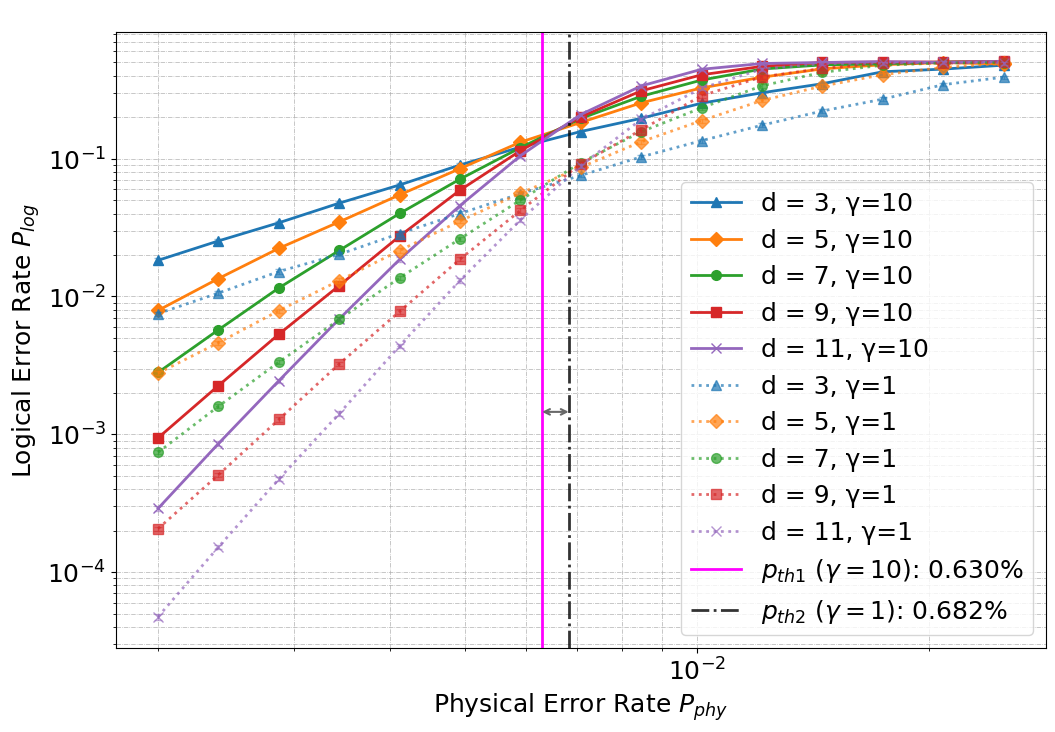

Generating plot for Function: Rotated_Direct, Direction: Vertical
Found intersection between d=3 and d=5: 0.007918605063557
Found intersection between d=5 and d=7: 0.007623976935398
Found intersection between d=7 and d=9: 0.007626747926712
Found intersection between d=9 and d=11: 0.007555691666618
Average threshold: 0.007681255398071
Found intersection between d=3 and d=5: 0.008072861733970
Found intersection between d=5 and d=7: 0.007923261893162
Found intersection between d=7 and d=9: 0.007669436748413
Found intersection between d=9 and d=11: 0.007619310935233
Average threshold: 0.007821217827694
Threshold p for set1 (Rotated_Direct γ=10): 0.007681
Threshold p for set2 (Rotated_Direct γ=1): 0.007821

--- DEBUGGING sinter.fit_binomial CALL (Dataset 2, d=9, k=1, N=30M) ---
  Physical Error Rate: 0.0023954147027895546
  Inputs: num_hits=1, num_shots=30000000, factor=6.82
  Output Fit object: low=2e-09, best=3.3333333333333334e-08, high=1.4666666666666668e-07
----------------------------

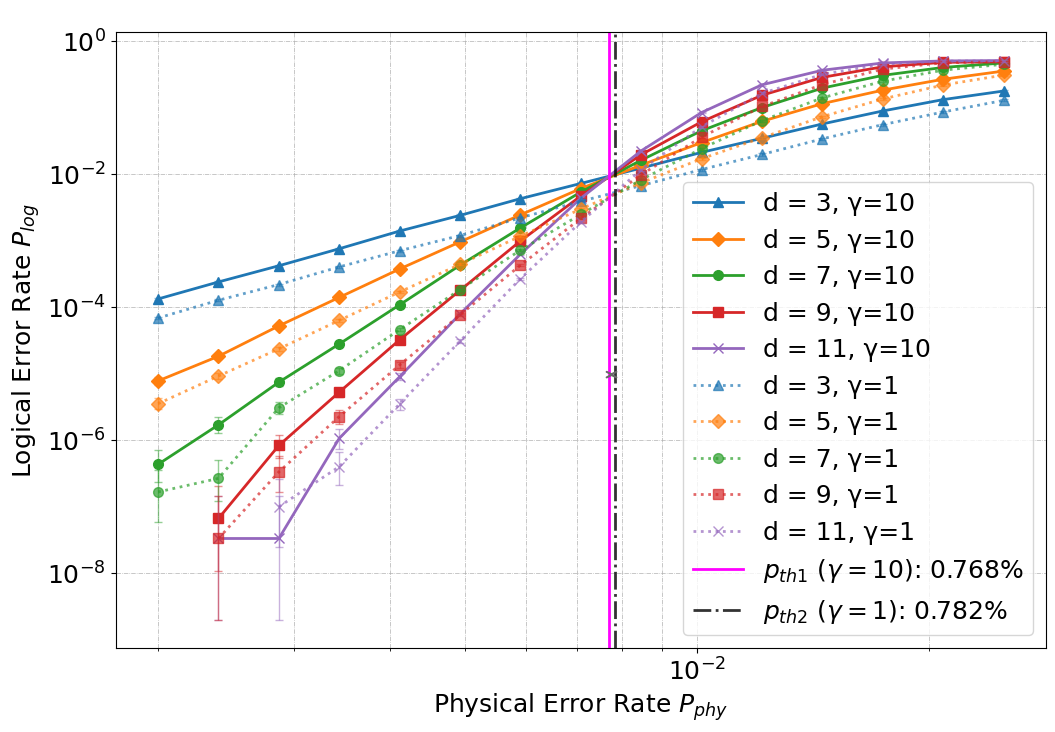

Generating plot for Function: Rotated_CAT, Direction: Horizontal
Found intersection between d=3 and d=5: 0.004911630002375
Found intersection between d=5 and d=7: 0.006053984388072
Found intersection between d=7 and d=9: 0.005724943451385
Found intersection between d=9 and d=11: 0.005708648395299
Average threshold: 0.005599801559283
Found intersection between d=3 and d=5: 0.004991119261852
Found intersection between d=5 and d=7: 0.005980565414700
Found intersection between d=7 and d=9: 0.005899871454852
Found intersection between d=9 and d=11: 0.006292827151415
Average threshold: 0.005791095820705
Threshold p for set1 (Rotated_CAT γ=10): 0.005600
Threshold p for set2 (Rotated_CAT γ=1): 0.005791
Plot saved to Results_With_95%_CI\Rotated_CAT_Horizontal_gamma10_gamma1.pdf


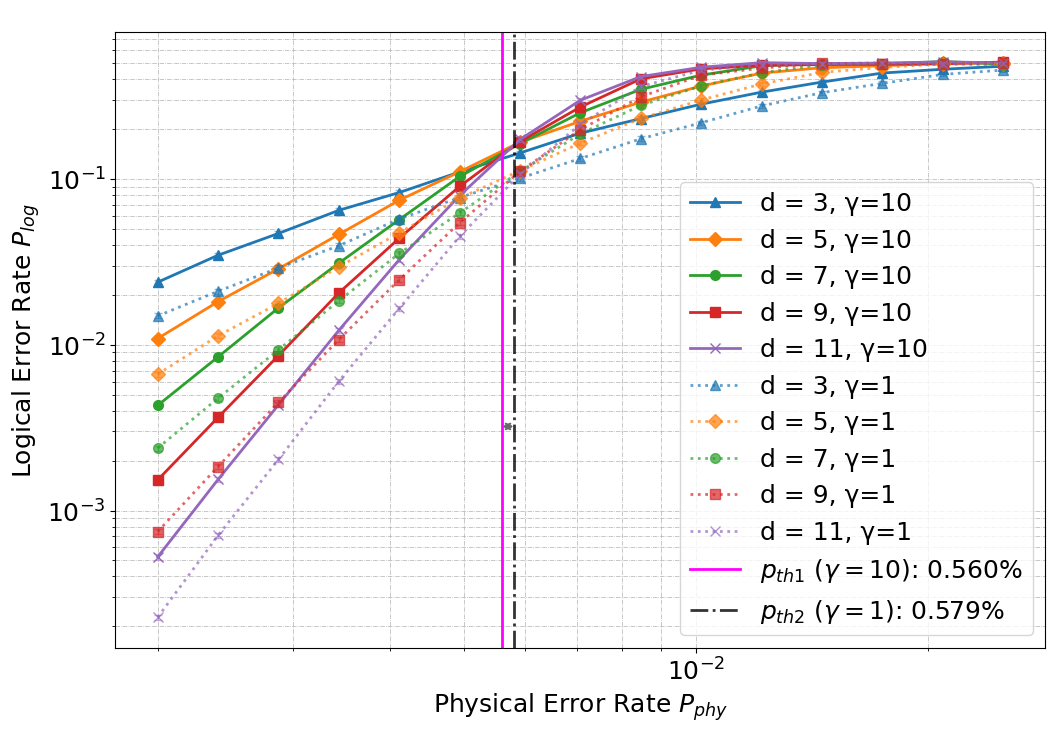

Generating plot for Function: Rotated_CAT, Direction: Vertical
Found intersection between d=3 and d=5: 0.006551587552299
Found intersection between d=5 and d=7: 0.006523361369061
Found intersection between d=7 and d=9: 0.006360201596302
Found intersection between d=9 and d=11: 0.006473317650139
Average threshold: 0.006477117041950
Found intersection between d=3 and d=5: 0.006788571385751
Found intersection between d=5 and d=7: 0.006597932155548
Found intersection between d=7 and d=9: 0.006473898142940
Found intersection between d=9 and d=11: 0.006481130767603
Average threshold: 0.006585383112961
Threshold p for set1 (Rotated_CAT γ=10): 0.006477
Threshold p for set2 (Rotated_CAT γ=1): 0.006585

--- DEBUGGING sinter.fit_binomial CALL (Dataset 2, d=9, k=1, N=30M) ---
  Physical Error Rate: 0.002
  Inputs: num_hits=1, num_shots=30000000, factor=6.82
  Output Fit object: low=2e-09, best=3.3333333333333334e-08, high=1.4666666666666668e-07
-----------------------------------------------------

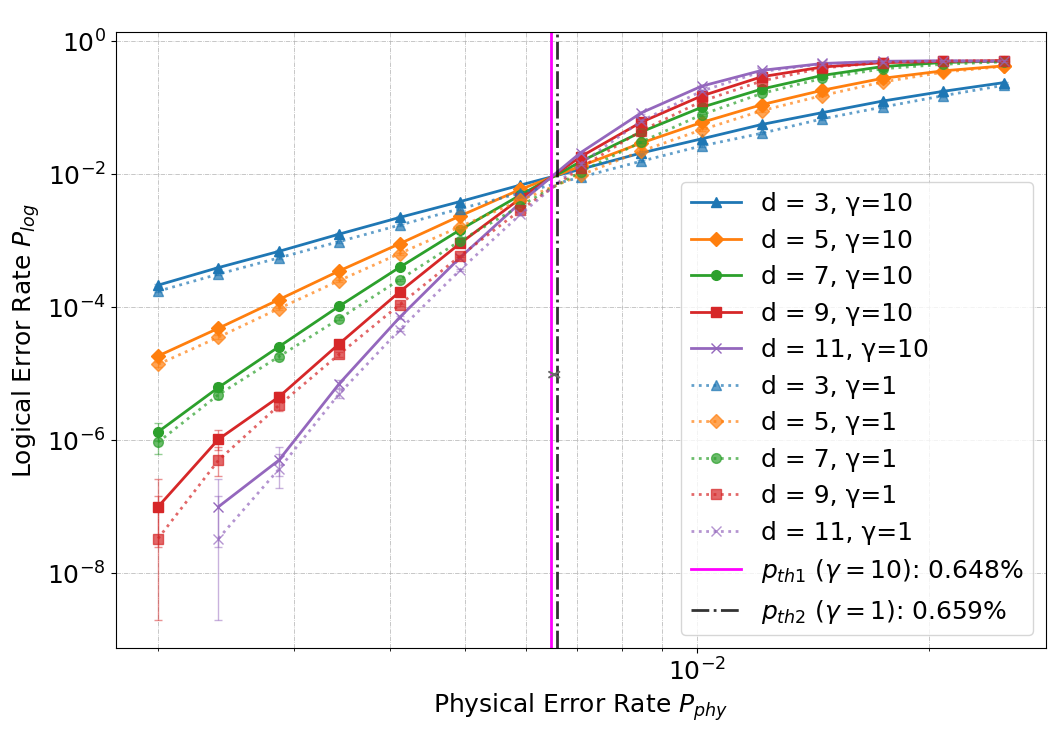

Generating plot for Function: Rotated_GT, Direction: Horizontal
Found intersection between d=3 and d=5: 0.005097360063762
Found intersection between d=5 and d=7: 0.005134466969150
Found intersection between d=7 and d=9: 0.005855023310499
Found intersection between d=9 and d=11: 0.005625598061966
Average threshold: 0.005428112101344
Found intersection between d=3 and d=5: 0.005117576322265
Found intersection between d=5 and d=7: 0.005873885691127
Found intersection between d=7 and d=9: 0.005973697784256
Found intersection between d=9 and d=11: 0.006219598420081
Average threshold: 0.005796189554433
Threshold p for set1 (Rotated_GT γ=10): 0.005428
Threshold p for set2 (Rotated_GT γ=1): 0.005796
Plot saved to Results_With_95%_CI\Rotated_GT_Horizontal_gamma10_gamma1.pdf


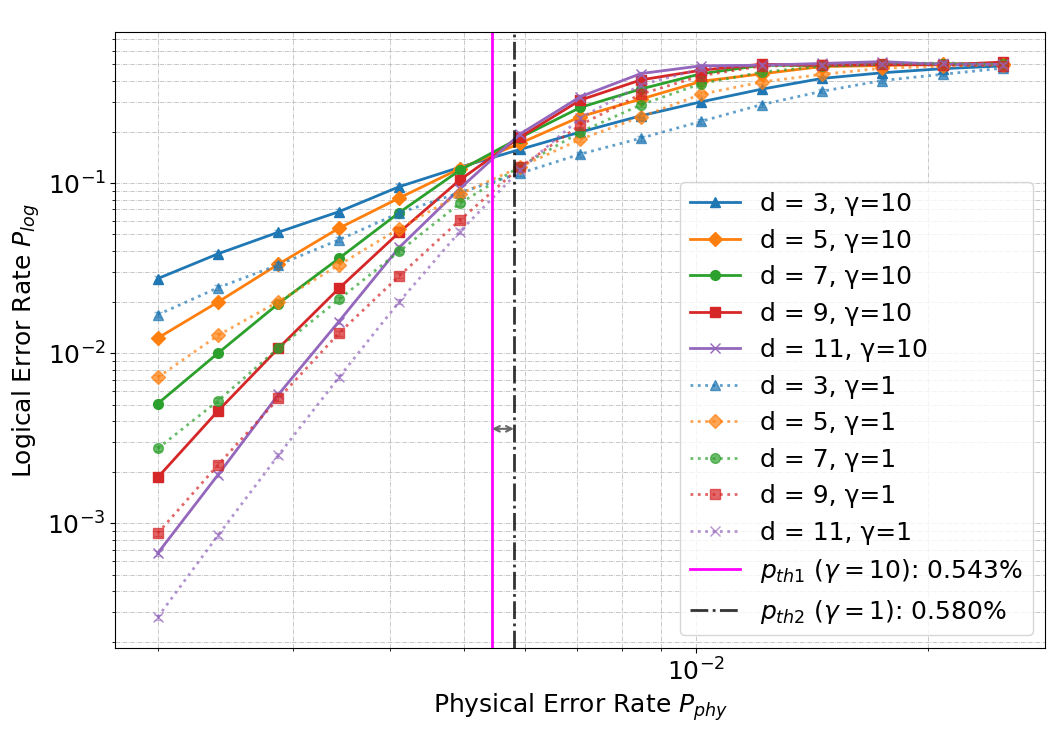

Generating plot for Function: Rotated_GT, Direction: Vertical
Found intersection between d=3 and d=5: 0.006650315497107
Found intersection between d=5 and d=7: 0.006371014175497
Found intersection between d=7 and d=9: 0.006378005005487
Found intersection between d=9 and d=11: 0.006469670923523
Average threshold: 0.006467251400403
Found intersection between d=3 and d=5: 0.006989097219708
Found intersection between d=5 and d=7: 0.006373444586616
Found intersection between d=7 and d=9: 0.006354706770854
Found intersection between d=9 and d=11: 0.006570165979114
Average threshold: 0.006571853639073
Threshold p for set1 (Rotated_GT γ=10): 0.006467
Threshold p for set2 (Rotated_GT γ=1): 0.006572
Plot saved to Results_With_95%_CI\Rotated_GT_Vertical_gamma10_gamma1.pdf


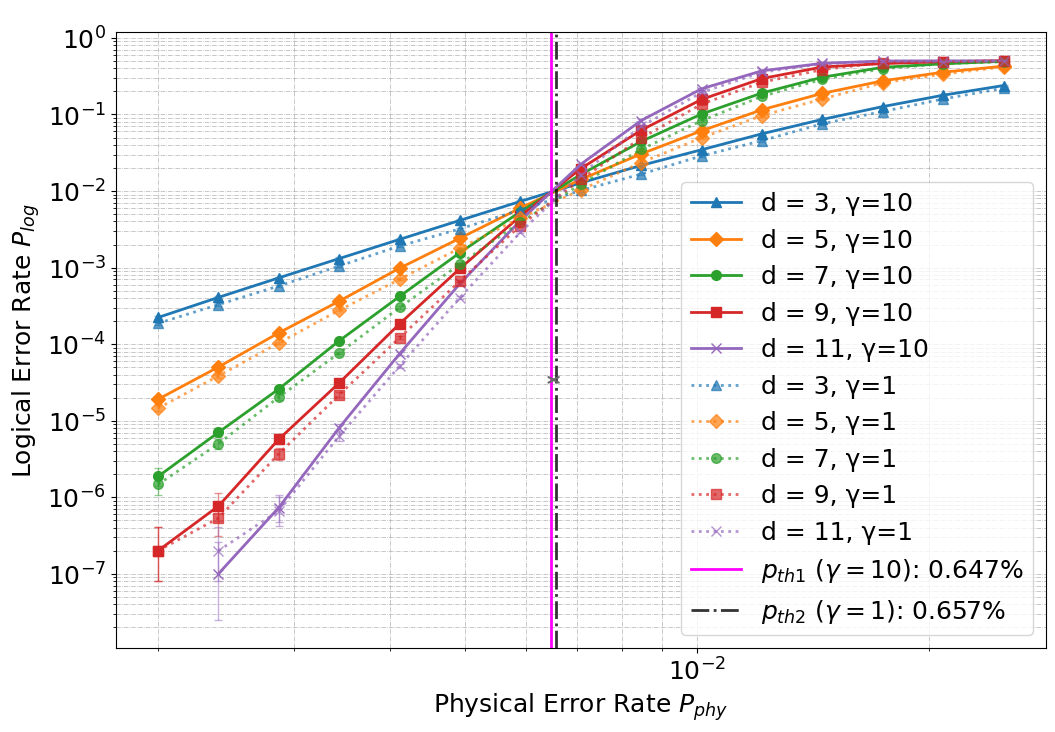

Generating plot for Function: Unrotated_Direct, Direction: Horizontal
Found intersection between d=3 and d=5: 0.007260155276607
Found intersection between d=5 and d=7: 0.007301170886799
Found intersection between d=7 and d=9: 0.007427891759746
Found intersection between d=9 and d=11: 0.007123517398538
Average threshold: 0.007278183830422
Found intersection between d=3 and d=5: 0.007784744431497
Found intersection between d=5 and d=7: 0.007708623231785
Found intersection between d=7 and d=9: 0.007509503671888
Found intersection between d=9 and d=11: 0.007372323525592
Average threshold: 0.007593798715190
Threshold p for set1 (Unrotated_Direct γ=10): 0.007278
Threshold p for set2 (Unrotated_Direct γ=1): 0.007594
Plot saved to Results_With_95%_CI\Unrotated_Direct_Horizontal_gamma10_gamma1.pdf


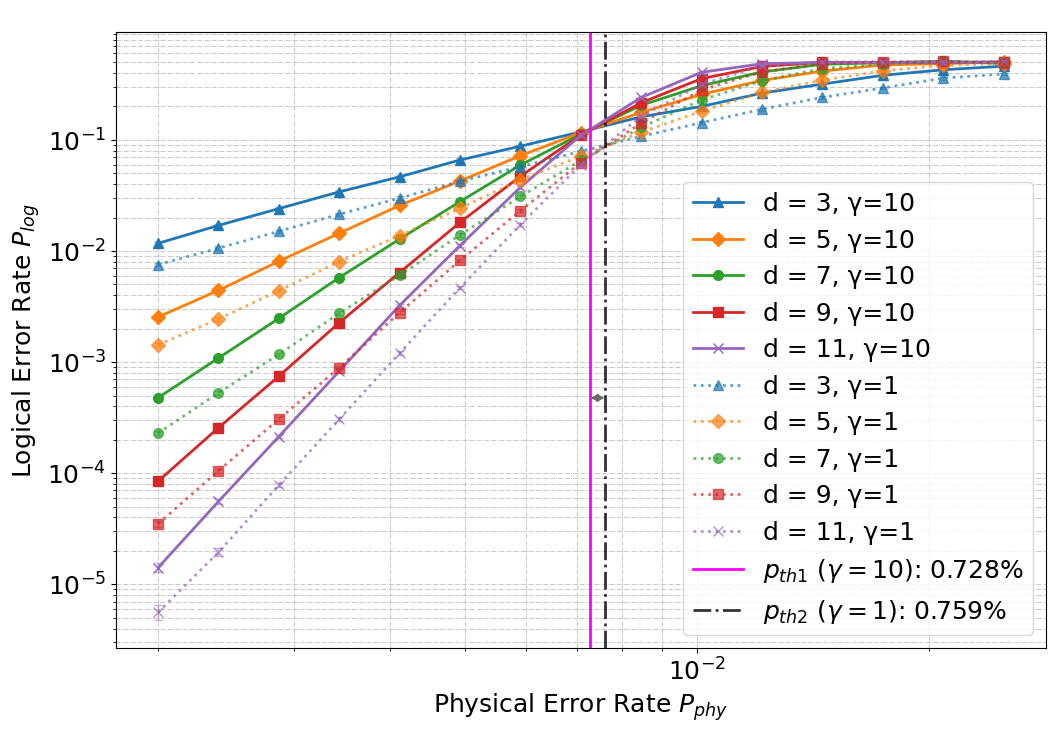

Generating plot for Function: Unrotated_Direct, Direction: Vertical
Found intersection between d=3 and d=5: 0.007817942848819
Found intersection between d=5 and d=7: 0.007603664356733
Found intersection between d=7 and d=9: 0.007615457536789
Found intersection between d=9 and d=11: 0.007602409877993
Average threshold: 0.007659868655083
Found intersection between d=3 and d=5: 0.007842988260061
Found intersection between d=5 and d=7: 0.007671172078999
Found intersection between d=7 and d=9: 0.007580603525251
Found intersection between d=9 and d=11: 0.007531874848940
Average threshold: 0.007656659678313
Threshold p for set1 (Unrotated_Direct γ=10): 0.007660
Threshold p for set2 (Unrotated_Direct γ=1): 0.007657
Plot saved to Results_With_95%_CI\Unrotated_Direct_Vertical_gamma10_gamma1.pdf


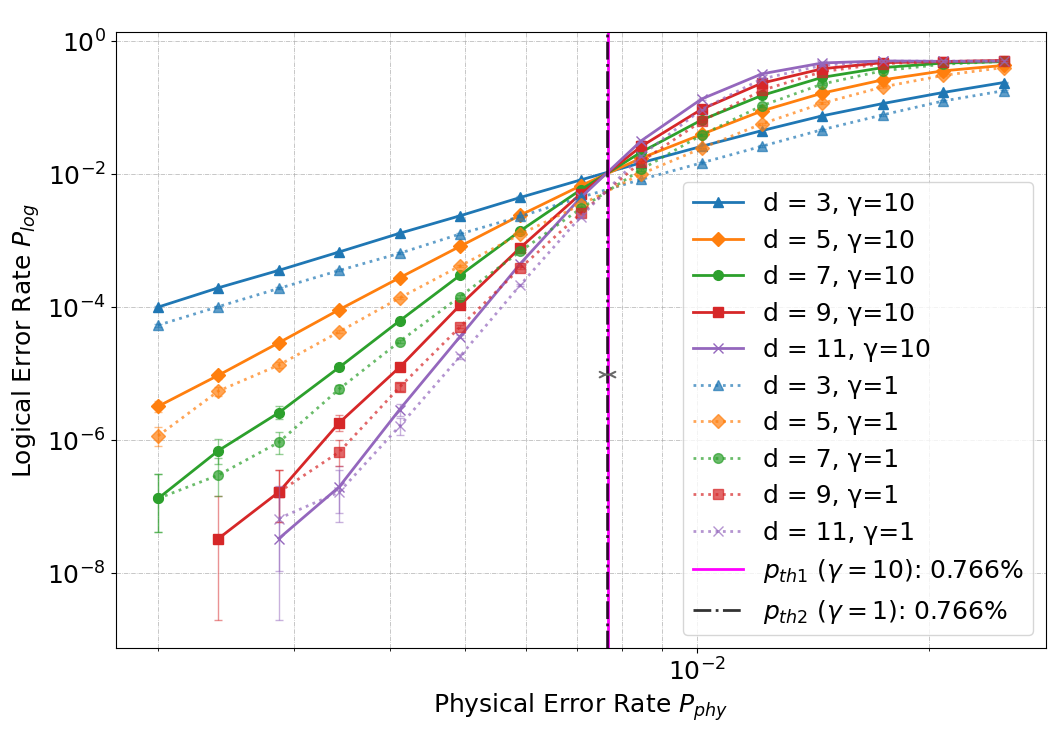

Generating plot for Function: unrotated_CAT, Direction: Horizontal
Found intersection between d=3 and d=5: 0.006177835168346
Found intersection between d=5 and d=7: 0.006071266794676
Found intersection between d=7 and d=9: 0.006087402218014
Found intersection between d=9 and d=11: 0.005969978920429
Average threshold: 0.006076620775366
Found intersection between d=3 and d=5: 0.005983977117942
Found intersection between d=5 and d=7: 0.006435433025037
Found intersection between d=7 and d=9: 0.006482759281692
Found intersection between d=9 and d=11: 0.006130873644761
Average threshold: 0.006258260767358
Threshold p for set1 (unrotated_CAT γ=10): 0.006077
Threshold p for set2 (unrotated_CAT γ=1): 0.006258
Plot saved to Results_With_95%_CI\unrotated_CAT_Horizontal_gamma10_gamma1.pdf


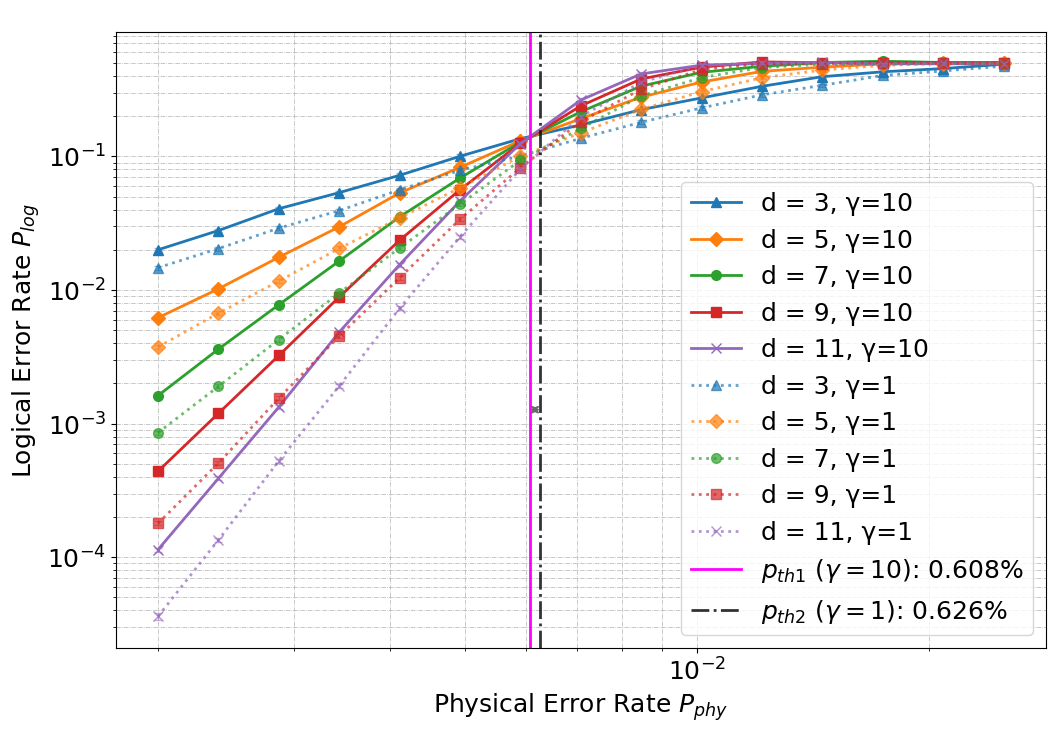

Generating plot for Function: unrotated_CAT, Direction: Vertical
Found intersection between d=3 and d=5: 0.006408847424646
Found intersection between d=5 and d=7: 0.006059916490396
Found intersection between d=7 and d=9: 0.006319913981769
Found intersection between d=9 and d=11: 0.006231340235785
Average threshold: 0.006255004533149
Found intersection between d=3 and d=5: 0.006524711956825
Found intersection between d=5 and d=7: 0.006420480905617
Found intersection between d=7 and d=9: 0.006299664808244
Found intersection between d=9 and d=11: 0.006352532684727
Average threshold: 0.006399347588853
Threshold p for set1 (unrotated_CAT γ=10): 0.006255
Threshold p for set2 (unrotated_CAT γ=1): 0.006399
Plot saved to Results_With_95%_CI\unrotated_CAT_Vertical_gamma10_gamma1.pdf


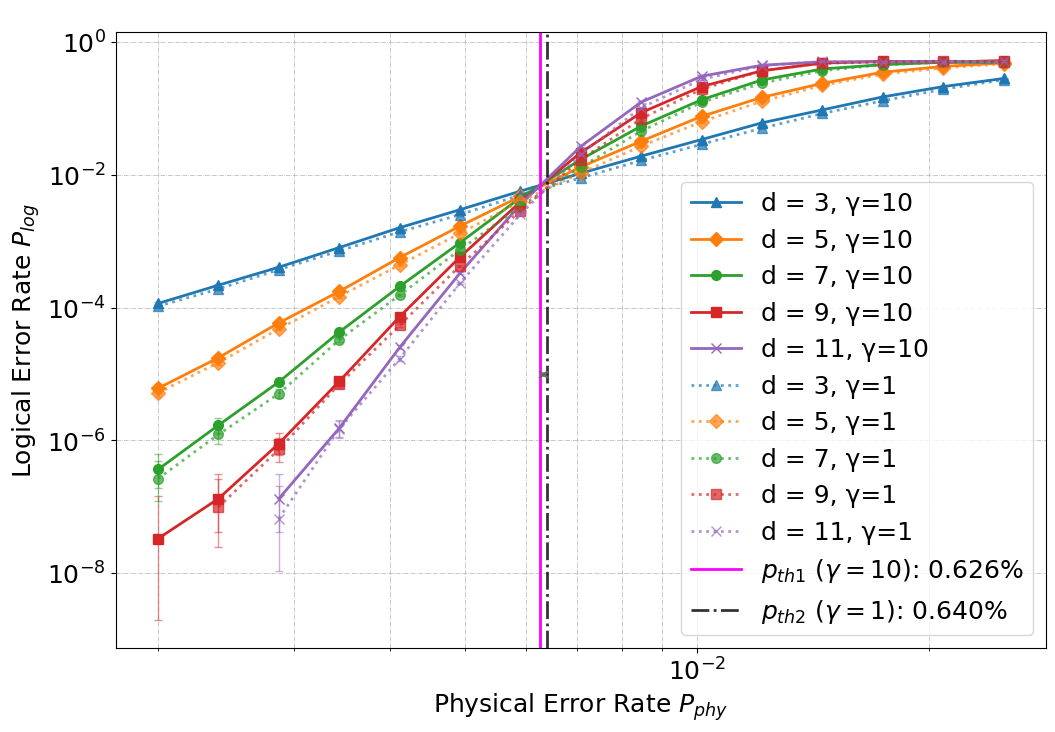

Generating plot for Function: unrotated_GT, Direction: Horizontal
Found intersection between d=3 and d=5: 0.005473730892436
Found intersection between d=5 and d=7: 0.005724955663271
Found intersection between d=7 and d=9: 0.006078805655818
Found intersection between d=9 and d=11: 0.005713346475019
Average threshold: 0.005747709671636
Found intersection between d=3 and d=5: 0.006279701754386
Found intersection between d=5 and d=7: 0.005858179361568
Found intersection between d=7 and d=9: 0.006172849005171
Found intersection between d=9 and d=11: 0.006259714499712
Average threshold: 0.006142611155209
Threshold p for set1 (unrotated_GT γ=10): 0.005748
Threshold p for set2 (unrotated_GT γ=1): 0.006143
Plot saved to Results_With_95%_CI\unrotated_GT_Horizontal_gamma10_gamma1.pdf


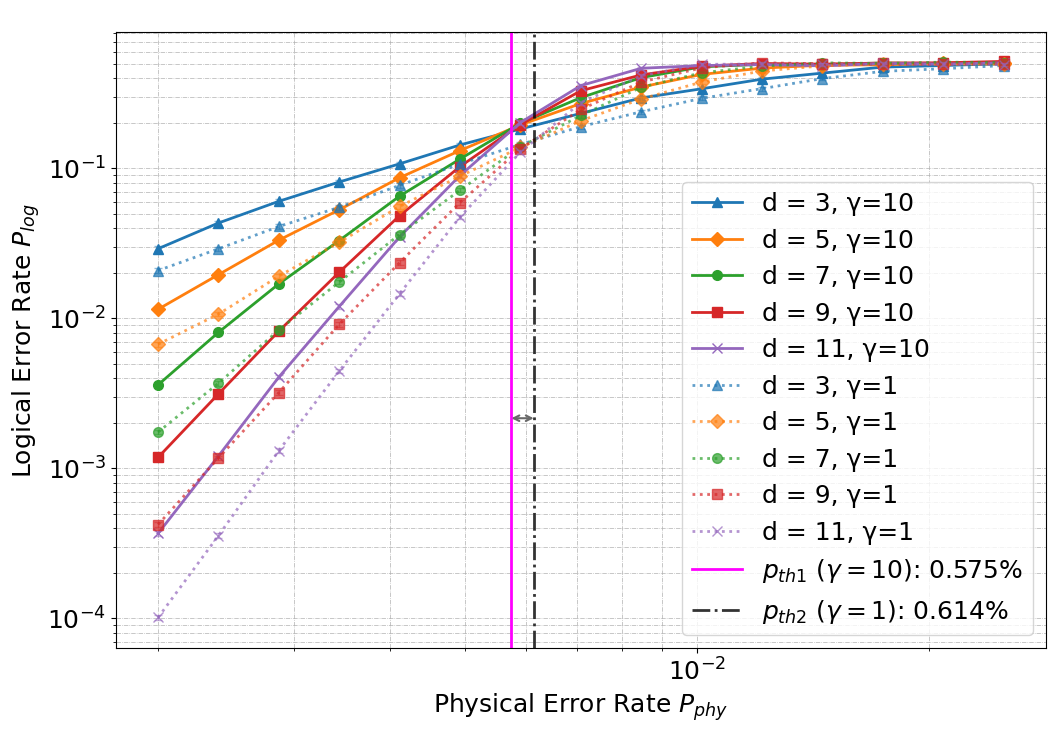

Generating plot for Function: unrotated_GT, Direction: Vertical
Found intersection between d=3 and d=5: 0.006790220216062
Found intersection between d=5 and d=7: 0.006391641898340
Found intersection between d=7 and d=9: 0.006376086852124
Found intersection between d=9 and d=11: 0.006349394230684
Average threshold: 0.006476835799302
Found intersection between d=3 and d=5: 0.006904573882345
Found intersection between d=5 and d=7: 0.006674751503220
Found intersection between d=7 and d=9: 0.006453537594217
Found intersection between d=9 and d=11: 0.006405165414731
Average threshold: 0.006609507098628
Threshold p for set1 (unrotated_GT γ=10): 0.006477
Threshold p for set2 (unrotated_GT γ=1): 0.006610
Plot saved to Results_With_95%_CI\unrotated_GT_Vertical_gamma10_gamma1.pdf


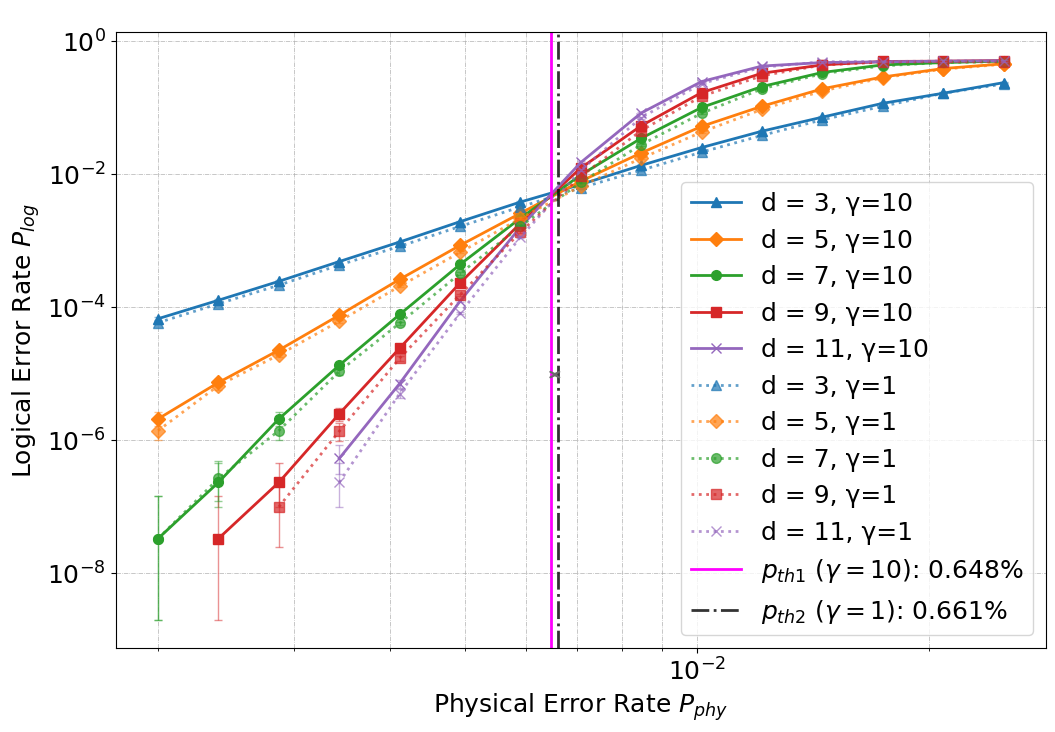


Thresholds summary:
            Function   Direction  Multiplier1  Threshold1  Multiplier2  \
0     Rotated_Direct  Horizontal           10    0.006299            1   
1     Rotated_Direct    Vertical           10    0.007681            1   
2        Rotated_CAT  Horizontal           10    0.005600            1   
3        Rotated_CAT    Vertical           10    0.006477            1   
4         Rotated_GT  Horizontal           10    0.005428            1   
5         Rotated_GT    Vertical           10    0.006467            1   
6   Unrotated_Direct  Horizontal           10    0.007278            1   
7   Unrotated_Direct    Vertical           10    0.007660            1   
8      unrotated_CAT  Horizontal           10    0.006077            1   
9      unrotated_CAT    Vertical           10    0.006255            1   
10      unrotated_GT  Horizontal           10    0.005748            1   
11      unrotated_GT    Vertical           10    0.006477            1   

    Threshold2  

In [8]:
import os
import pandas as pd
function_names = ["Rotated_Direct","Rotated_CAT","Rotated_GT","Unrotated_Direct","unrotated_CAT","unrotated_GT"] 
directions = ["Horizontal", "Vertical"]

multiplier1 = 10
multiplier2 = 1

likelihood_factor = 6.82
#6.82 For ~95% Confidence Interval look

save_folder = "Results_With_95%_CI" 
os.makedirs(save_folder, exist_ok=True)

thresholds_list = []

for func_name in function_names: 
    for direction_key in directions: 
        save_filename = f"{func_name}_{direction_key}_gamma{multiplier1}_gamma{multiplier2}.pdf" 
        save_path = os.path.join(save_folder, save_filename)
        
        print(f"Generating plot for Function: {func_name}, Direction: {direction_key}")
        
        p_threshold1, p_threshold2 = plot_two_simulation_results(
            results_dict, 
            function_name1=func_name,
            direction1=direction_key,
            multiplier1=multiplier1,
            function_name2=func_name, 
            direction2=direction_key,
            multiplier2=multiplier2,
            save_path=save_path,
            max_likelihood_factor_for_ci=likelihood_factor 
        )
        
        thresholds_list.append({
            'Function': func_name,
            'Direction': direction_key,
            'Multiplier1': multiplier1,
            'Threshold1': p_threshold1 if p_threshold1 is not None else 'N/A',
            'Multiplier2': multiplier2,
            'Threshold2': p_threshold2 if p_threshold2 is not None else 'N/A' 
        })

df_thresholds = pd.DataFrame(thresholds_list)
print("\nThresholds summary:")
print(df_thresholds)

csv_save_path = os.path.join(save_folder, "thresholds_summary.csv") 
df_thresholds.to_csv(csv_save_path, index=False)
print(f"Thresholds summary saved to {csv_save_path}")